In [1]:
import pandas as pd
import lzma

df_reddit = pd.read_csv(
    lzma.open("../data/reddit_opinion_PSE_ISR.csv.lzma"), low_memory=False)

df_acled = pd.read_csv("../data/acled_middle_east_data.csv")

/var/folders/8s/5kb_fl851lbfqsvhg3z5m8ww0000gn/T/ipykernel_35277/1915750956.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_reddit.columns

Index(['comment_id', 'score', 'self_text', 'subreddit', 'created_time',
       'post_id', 'author_name', 'controversiality', 'ups', 'downs',
       'user_is_verified', 'user_account_created_time', 'user_awardee_karma',
       'user_awarder_karma', 'user_link_karma', 'user_comment_karma',
       'user_total_karma', 'post_score', 'post_self_text', 'post_title',
       'post_upvote_ratio', 'post_thumbs_ups', 'post_total_awards_received',
       'post_created_time'],
      dtype='object')

In [29]:
df_reddit['created_time'].min(), df_reddit['created_time'].max(
), (df_reddit['created_time'].max() - df_reddit['created_time'].min()).days-5

(Timestamp('2023-09-02 00:00:00'), Timestamp('2023-12-15 00:00:00'), 99)

- do sentiment analysis --> percent positive / negative in last 7 days
- things to evaluate over 7 days


In [39]:
import pandas as pd
from datetime import timedelta
import math

# DON"T RUN THE REST OF THIS UNLESS YOU WANT TO CHANGE PREV_DAYS AND CREATE THE DATASET ALL OVER

PREV_DAYS = 5

seven_days_avg_df = pd.DataFrame()

df_reddit['user_account_created_time'] = pd.to_datetime(
    df_reddit['user_account_created_time']).dt.normalize()

df_acled['event_date'] = pd.to_datetime(
    df_acled['event_date']).dt.normalize()

df_reddit['created_time'] = pd.to_datetime(
    df_reddit['created_time']).dt.normalize()

periods_between = math.ceil((df_reddit['created_time'].max() -
                             df_reddit['created_time'].min()).days/PREV_DAYS)

dyas_between = (df_reddit['created_time'].max() -
                df_reddit['created_time'].min()).days-5
times = [df_reddit['created_time'].min() + timedelta(days=i)
         for i in range(5, dyas_between+1)]

df_reddit.dropna(subset=['created_time', 'controversiality', "user_is_verified",
                 "user_total_karma", "post_total_awards_received"], inplace=True)

for time in times:
    events_count = df_acled.loc[df_acled["event_date"]
                                < time]["event_date"].count()
    filtered_reddit = df_reddit.loc[df_reddit["created_time"] < time]

    total_posts = filtered_reddit.shape[0]
    if total_posts > 0:
        percentage_controversial_posts = filtered_reddit['controversiality'].sum(
        ) / total_posts * 100
        percentage_verified_users = filtered_reddit['user_is_verified'].sum(
        ) / total_posts * 100
        avg_user_total_karma = filtered_reddit["user_total_karma"].mean()
        sum_post_awards_received = filtered_reddit["post_total_awards_received"].sum(
        )
        avg_post_score = filtered_reddit["score"].mean()
        min_max_post_range = filtered_reddit["score"].max(
        ) - filtered_reddit["score"].min()
        percentage_acc_created_last_month = (filtered_reddit.loc[filtered_reddit['user_account_created_time'] > (
            time-timedelta(days=93))].shape[0] / total_posts) * 100
        avg_comment_karma_recieved = filtered_reddit["user_comment_karma"].mean(
        )
    else:
        percentage_controversial_posts = 0
        percentage_verified_users = 0
        avg_user_total_karma = 0
        avg_post_awards_received = 0

    temp_df = pd.DataFrame([{
        'events_count': events_count,
        'percentage_controversial_posts': percentage_controversial_posts,
        'percentage_verified_users': percentage_verified_users,
        'sum_post_awards_received': sum_post_awards_received,
        'avg_user_total_karma': avg_user_total_karma,
        'percentage_acc_created_last_month': percentage_acc_created_last_month,
        'avg_post_score': avg_post_score,
        'min_max_post_range': min_max_post_range,
        'avg_comment_karma_recieved': avg_comment_karma_recieved
    }])

    seven_days_avg_df = pd.concat(
        [seven_days_avg_df, temp_df], ignore_index=True)

seven_days_avg_df.to_csv(f'modified_{PREV_DAYS}_days.csv')

In [40]:
seven_days_avg_df = pd.read_csv(
    f'modified_{PREV_DAYS}_days.csv').drop(["Unnamed: 0"], axis=1)

seven_days_avg_df.shape

(95, 9)

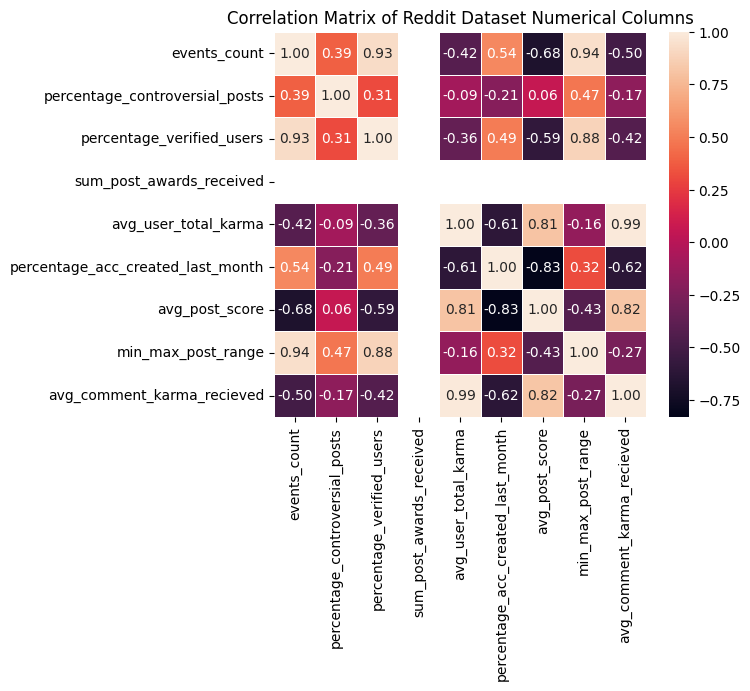

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = seven_days_avg_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Reddit Dataset Numerical Columns')
plt.show()

In [42]:
correlation_matrix["events_count"].sort_values()

avg_post_score                      -0.681813
avg_comment_karma_recieved          -0.504770
avg_user_total_karma                -0.419578
percentage_controversial_posts       0.389259
percentage_acc_created_last_month    0.543155
percentage_verified_users            0.927855
min_max_post_range                   0.937185
events_count                         1.000000
sum_post_awards_received                  NaN
Name: events_count, dtype: float64

In [ ]:
df_reddit.columns

Index(['comment_id', 'score', 'self_text', 'subreddit', 'created_time',
       'post_id', 'author_name', 'controversiality', 'ups', 'downs',
       'user_is_verified', 'user_account_created_time', 'user_awardee_karma',
       'user_awarder_karma', 'user_link_karma', 'user_comment_karma',
       'user_total_karma', 'post_score', 'post_self_text', 'post_title',
       'post_upvote_ratio', 'post_thumbs_ups', 'post_total_awards_received',
       'post_created_time', 'events_prev_7_days'],
      dtype='object')

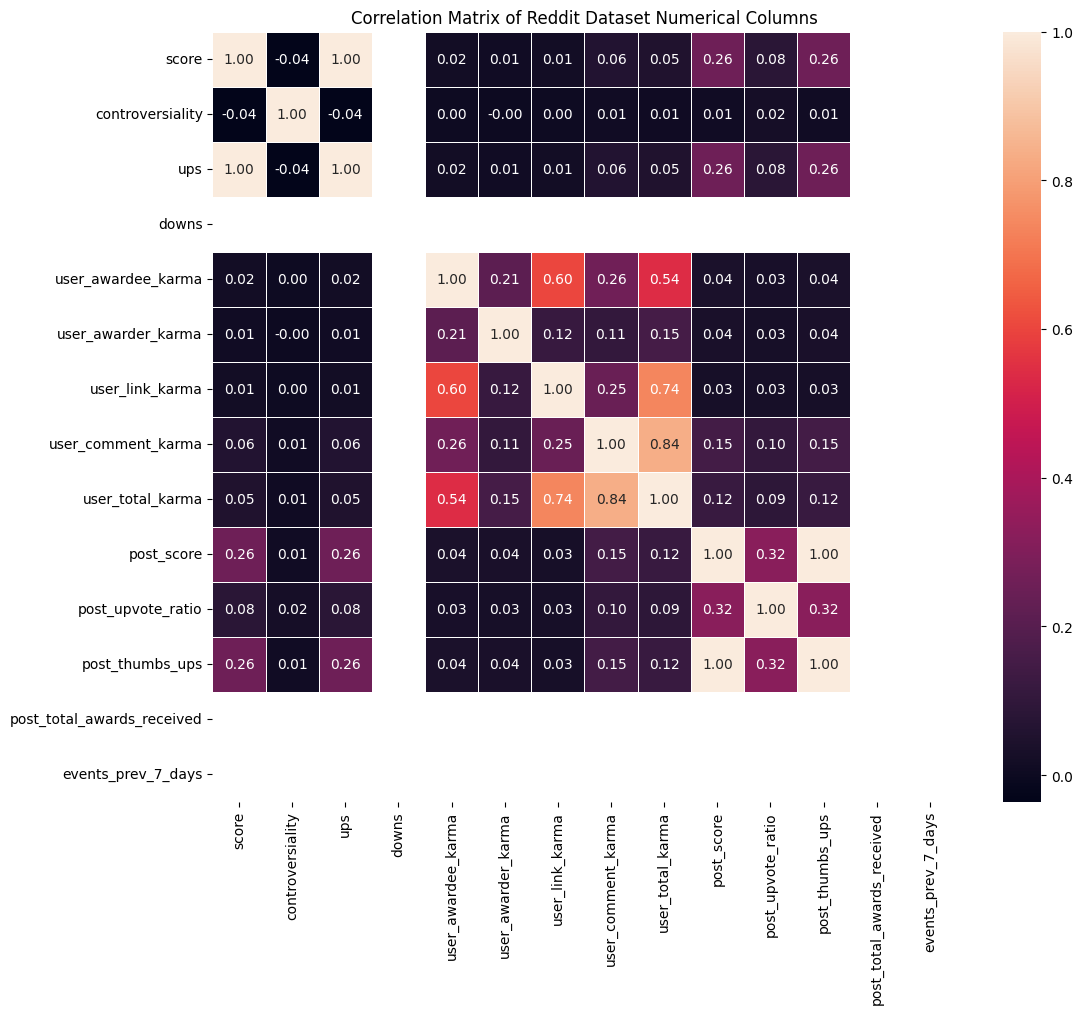

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_columns_reddit = df_reddit.select_dtypes(
    include=['int64', 'float64'])

correlation_matrix = numerical_columns_reddit.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Reddit Dataset Numerical Columns')
plt.show()

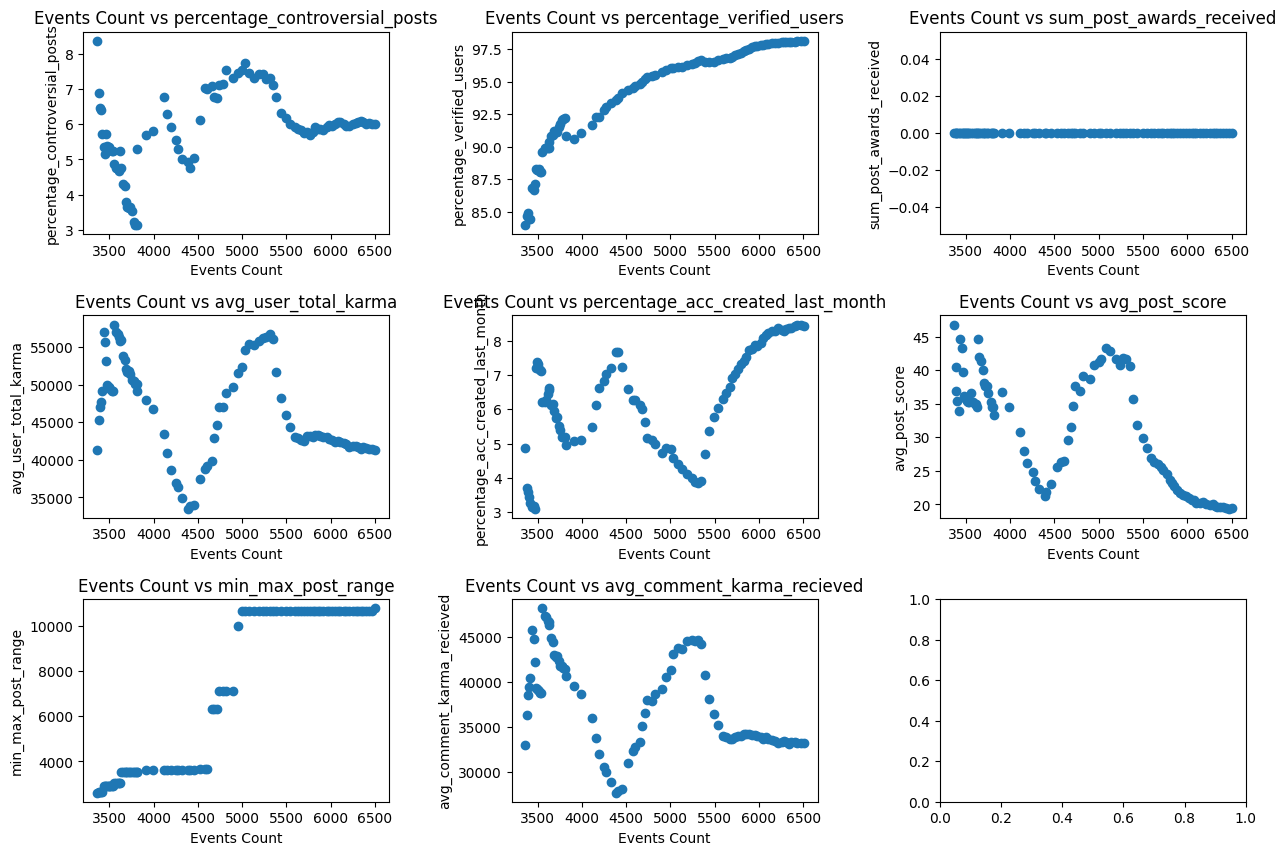

In [43]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, column in enumerate(seven_days_avg_df.columns[1:]):
    ax = axs[i//3, i % 3]
    ax.scatter(seven_days_avg_df["events_count"],
               seven_days_avg_df[column])
    ax.set_title(f'Events Count vs {column}')
    ax.set_xlabel('Events Count')
    ax.set_ylabel(column)


plt.show()

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = seven_days_avg_df.drop('events_count', axis=1)[["avg_post_score", "avg_comment_karma_recieved",

                                                    "percentage_acc_created_last_month", "percentage_verified_users", "min_max_post_range"]]
y = seven_days_avg_df['events_count']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [45]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

"Mse: ", mse, "r^2: ", r2

('Mse: ', 22624.803892089327, 'r^2: ', 0.9746956729563856)

In [25]:
seven_days_avg_df.describe()

,events_count,percentage_controversial_posts,percentage_verified_users,sum_post_awards_received,avg_user_total_karma,percentage_acc_created_last_month,avg_post_score,min_max_post_range,avg_comment_karma_recieved
count,21.00000,21.000000,21.000000,21.0,21.000000,21.000000,21.000000,21.000000,21.000000
mean,4884.47619,5.947335,93.949492,0.0,46281.730847,6.381728,31.014899,7206.428571,37270.519788
std,1150.55398,1.136852,4.231085,0.0,6845.082873,1.597423,9.590366,3720.762188,5590.182341
min,3363.00000,3.662494,83.972125,0.0,33856.277671,3.159341,19.126360,2622.000000,27824.947867
25%,3738.00000,5.313496,90.867925,0.0,41406.599684,4.990365,21.804780,3543.000000,33266.568847
50%,4822.00000,5.948377,95.534587,0.0,43232.572184,6.207483,29.653780,7136.000000,34171.394518
75%,5884.00000,6.054416,97.563873,0.0,51382.115438,7.731211,39.071699,10668.000000,42344.742235
max,6709.00000,8.362369,98.256769,0.0,56985.826923,8.396071,46.773519,12356.000000,47309.926020
